In [1]:
import os
import glob
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

import astropy.io.fits as fits

import pyklip.klip as klip
import pyklip.spectra_management as sm
import pyklip.fakes as fakes
import pyklip.instruments.GPI as GPI
import pyklip.parallelized as parallelized

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/jwang/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


# Contrast Curve without Throughput Correction
Using the PSF-subtracted images from the Basic KLIP Tutorial notebook, we will measure the contrast assuming azimuthally uniform noise in the data. This first measurement does not account for algorithm throughput (i.e. PSF subtraction attenuates the flux of planets), but we will correct that later.

## Read in the data
We will use the KL=20 cutoff reduction to measure the contrast. The KL mode cutoff is a free parameter that you should optimize for your datasets. 

In [2]:
filename = "pyklip-betpic-j-131210-k100a9s4m1-KLmodes-all.fits"
klip_hdulist = fits.open(filename)
kl20frame = klip_hdulist[1].data[1]
dataset_center = [klip_hdulist[1].header['PSFCENTX'], klip_hdulist[1].header['PSFCENTY'] ]

## Measure uncorrected contrast
Now we will measure the contrast. We will use a gaussian cross-correlation as an optimization to remove high frequency noise (i.e. we know planets will be on the scale of $\sim\lambda/D$). The planets however have their PSF sizes shrunk a bit due to self-subtraction, so `low_pass_size` is a bit smaller than the FWHM ~ $\lambda/D$ and also corresponds to the $\sigma$ of the Gaussian. The fwhm parameter is still required though to correct for small number statistics that is applied due to finite sample size.

Note that we need to mask out $\beta$ Pic b, since it is not noise and would create a bump in our contrast curve if we assumed it was noise.

/home/jwang/GPI/klip/pyklip/pyklip/klip.py:540: RuntimeWarning: invalid value encountered in divide
  filtered /= filter_norm


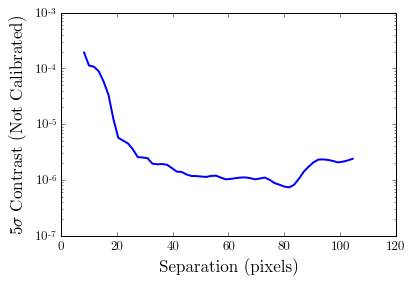

In [3]:
dataset_iwa = GPI.GPIData.fpm_diam['J']/2 # radius of occulter
dataset_owa = 1.5/GPI.GPIData.lenslet_scale # 1.5" is the furtherest out we will go
dataset_fwhm = 3.5 # fwhm of PSF roughly
low_pass_size = 1. # pixel, corresponds to the sigma of the Gaussian

# mask beta Pic b
# first get the location of the planet from Wang+ (2016)
betapicb_sep = 30.11 # pixels
betapicb_pa = 212.2 # degrees
betapicb_x = betapicb_sep * -np.sin(np.radians(betapicb_pa)) + dataset_center[0]
betapicb_y = betapicb_sep * np.cos(np.radians(betapicb_pa)) + dataset_center[1]
# now mask the data
ydat, xdat = np.indices(kl20frame.shape)
distance_from_planet = np.sqrt((xdat - betapicb_x)**2 + (ydat - betapicb_y)**2)
kl20frame[np.where(distance_from_planet <= 2*dataset_fwhm)] = np.nan


contrast_seps, contrast = klip.meas_contrast(kl20frame, dataset_iwa, dataset_owa, dataset_fwhm, center=dataset_center, low_pass_filter=low_pass_size)

plt.figure()
plt.plot(contrast_seps, contrast, 'b-', linewidth=2)
plt.xlabel("Separation (pixels)", fontsize=17)
plt.ylabel(r"$5\sigma$ Contrast (Not Calibrated)", fontsize=17)
plt.gca().tick_params(axis='both', labelsize=13)
plt.yscale("log")
plt.savefig("contrast_nothroughput.png", dpi=150)

# Throughput Correction with Fake Planets
Here we will demonstrate a very basic algorithm throughput correction with fake planets. We will only inject a few fake planets into the data and use them to measure the attenutation of flux from KLIP. This is just a demonstration of the pyKLIP API and you should probably investiagte how throughput varies with planet brightness, separation, and position angle in your own data.

## Reread in the data
Same thing as the basic KLIP tutorial

In [4]:
filelist = glob.glob("../tests/data/S20131210*distorcorr.fits")
filelist.sort()

dataset = GPI.GPIData(filelist, highpass=True)

Reading File: ../tests/data/S20131210S0092_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0111_spdc_distorcorr.fits


## Inject some make planets into the dataset

Now we will inject just a three sets of four fake planets into the dataset to demonstrate how it's done. You probably want to do this several times at many separations and PAs.

As in GPI data, the sky rotates through time, we use the WCS header in each image to figure out where to inject the planet.

In [5]:
# three sets, planets get fainter as contrast gets better further out
input_planet_fluxes = [1e-4, 1e-5, 5e-6]
seps = [20, 40, 60] 
fwhm = 3.5 # pixels, approximate for GPI

for input_planet_flux, sep in zip(input_planet_fluxes, seps):
    # inject 4 planets at that separation to improve noise
    # fake planets are injected in data number, not contrast units, so we need to convert the flux
    # for GPI, a convenient field dn_per_contrast can be used to convert the planet flux to raw data numbers
    injected_flux = input_planet_flux * dataset.dn_per_contrast
    for pa in [0, 90, 180, 270]:
        fakes.inject_planet(dataset.input, dataset.centers, injected_flux, dataset.wcs, sep, pa, fwhm=fwhm)

## Run KLIP with same parameters

To calibrate algorithm throughput, we need to do the same reduction with the same parameters as before. 

In [6]:
outputdir = "." # we are going to save the files in the same directory
prefix = "pyklip-betpic-j-131210-k100a9s4m1-fakeplanets" # a file prefix to summarize this reduction


parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=prefix,
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.11 with index 0 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.139 with index 3 has finished align and scale. Queuing for KLIP
Wavelength 1.133 with index 2 has finished align and scale. Queuing for KLIP
Wavelength 1.145 with index 4 has finished align and scale. Queuing for KLIP
Wavelength 1.157 with index 6 has finished align and scale. Queuing for KLIP
Wavelength 1.151 with index 5 has finished align and scale. Queuing for KLIP
Wavelength 1.163 with index 7 has finished align and scale. Queuing for KLIP
Wavelength 1.169 with index 8 has finished align and scale. Queuing for KLIP
Wavelength 1.174 with index 9 has finished align and scale. Queuing for KLIP
Wavelength 1.181 with index 10 has finished align and scale. Queuing for KLIP
Wavelength 1.187 with index 11 has finished align and scale. Queuing for KLIP
Wav

/home/jwang/GPI/klip/pyklip/pyklip/parallelized.py:1252: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(dataset.output, axis=(1,2))
/home/jwang/GPI/klip/pyklip/pyklip/parallelized.py:1266: RuntimeWarning: Mean of empty slice
  KLmode_spectral_cubes = np.nanmean(dataset.output, axis=1)


Writing Images to directory /home/jwang/GPI/klip/pyklip/examples


## Read back in the KL mode cube with fake planets

Here, we'll pick the 20 KL mode cutoff just as we did for the data without fakes. How we can see many fake planets, which form a cross.

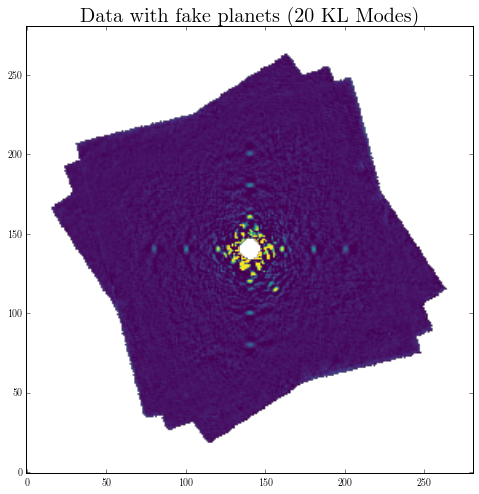

In [7]:
# Read in the data and grab the data from the HDU card in index 1
kl_hdulist = fits.open("{out}/{pre}-KLmodes-all.fits".format(out=outputdir, pre=prefix))
dat_with_fakes = kl_hdulist[1].data[1]
dat_with_fakes_centers = [kl_hdulist[1].header['PSFCENTX'], kl_hdulist[1].header['PSFCENTY'] ]



plt.figure(figsize=(8,8))
plt.imshow(dat_with_fakes, cmap='viridis', vmin=-5e-7, vmax=1e-5)
plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
plt.title("Data with fake planets (20 KL Modes)", fontsize=20)
plt.savefig("betapic_withfakes.png", dpi=150)


## Measure the average flux of planets at each separation

Note that we will be lazy here are use the dataset.wcs in the GPIData object, which is updated after derotation so that the WCS specifies North is up and East is left. We also need to supply a center, which gets written to the header of the reduced GPI data after KLIP. 


In [8]:
retrieved_fluxes = [] # will be populated, one for each separation

for input_planet_flux, sep in zip(input_planet_fluxes, seps):
    fake_planet_fluxes = []
    for pa in [0, 90, 270, 360]:
        fake_flux = fakes.retrieve_planet_flux(dat_with_fakes, dat_with_fakes_centers, dataset.wcs[0], sep, pa, searchrad=7)
        fake_planet_fluxes.append(fake_flux)
    retrieved_fluxes.append(np.mean(fake_planet_fluxes))

print(retrieved_fluxes)

[1.242994502104714e-05, 4.6805503414814094e-06, 3.3774402273247037e-06]


# Calibrate contrast curves

We will now roughly calibrate the contrast curves, by picking the fake planet throughput closest in separation for each point in the contrast curve.

And now we have a rough contrast curve for this dataset! You'll probably want to inject more fake planets at all separations to really understand how the throughput changes spatially though!

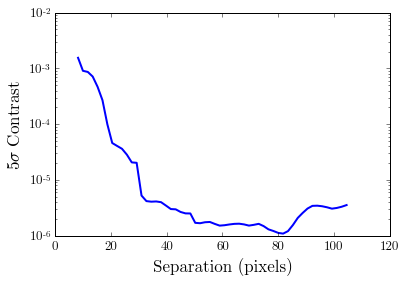

In [9]:
# fake planet output / fake planet input = throughput of KLIP
algo_throughput = np.array(retrieved_fluxes)/np.array(input_planet_fluxes) # a number less than 1 probably

corrected_contrast_curve = np.copy(contrast)
for i, sep in enumerate(contrast_seps):
    closest_throughput_index = np.argmin(np.abs(sep - seps))
    corrected_contrast_curve[i] /= algo_throughput[closest_throughput_index]
    
plt.figure()
plt.plot(contrast_seps, corrected_contrast_curve, 'b-', linewidth=2)
plt.xlabel("Separation (pixels)", fontsize=17)
plt.ylabel(r"$5\sigma$ Contrast", fontsize=17)
plt.gca().tick_params(axis='both', labelsize=13)
plt.yscale("log")
plt.savefig("contrast_calibrated.png", dpi=150)